# Stock Price Prediction

### Task
* 모델 및 하이퍼파라미터들을 바꿔가며 accuracy를 높혀 보자
* 밑에 제시된 여러가지 시도를 해보자
* The main flow of this code is referenced in this [blog](https://medium.com/@aniruddha.choudhury94/stock-market-prediction-by-recurrent-neural-network-on-lstm-model-56de700bff68)
* 주식데이터를 직접 다운 받아서 실제 예측을 해보자
  * Train data: 2017년 1월 1일 ~ 2019년 12월 31일 데이터
  * Test data: 2019년 1월 1일 ~ 2019년 2월 28일 데이터
  * Close price 예측 (baseline은 open price)

### Dataset
* [Yahoo finance datasets](https://www.imdb.com/interfaces/)
* 2-3년간 daily stock price 데이터를 이용하여 미래 한달의 주식가격을 예측

### Baseline code
* Dataset: train, test로 split
* Input data shape: (`batch_size`, `past_day`=60, 1)
* Output data shape: (`batch_size`, 1)
* Architecture: 
  * `LSTM` - `Dense`
  * [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) 사용
* Training
  * `model.fit` 사용
* Evaluation
  * `model.evaluate` 사용 for test dataset

### Try some techniques
* Change model architectures (Custom model)
  * Use another cells (LSTM, GRU, etc.)
  * Use dropout layers
  * Change the `past_day`
* Data augmentation (if possible)
* Try Early stopping
* Use various features (open, high, low, close prices and volume features)

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display

import tensorflow as tf
from tensorflow.keras import layers
tf.enable_eager_execution()

tf.logging.set_verbosity(tf.logging.INFO)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Data Download

* We colud download daliy stock price using `fix_yahoo_finance` library.
* Some stock ticker symbols [NASDAQ] [link](http://eoddata.com/symbols.aspx)
  * `AAPL`: Apple Inc.
  * `AMZM`: Amazon.com Inc.
  * `GOOG`: Alphabet Class C (Google)
  * `MSFT`: Microsoft Corp.

In [2]:
import fix_yahoo_finance as yf

dataset = yf.download(tickers='MSFT', start='2017-01-01', end='2019-01-01', auto_adjust=True)

/home/user/anaconda3/lib/python3.7/site-packages/fix_yahoo_finance/__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance



[*********************100%***********************]  1 of 1 downloaded


In [3]:
dataset.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,59.90,59.94,59.27,59.69,20694100
2017-01-04,59.60,59.86,59.26,59.43,21340000
2017-01-05,59.32,59.77,59.17,59.43,24876000
2017-01-06,59.43,60.24,59.18,59.94,19922900
2017-01-09,59.87,60.17,59.66,59.75,20382700


### Data Preprocessing

1. Data discretization: Part of data reduction but with particular importance, especially for numerical data
2. Data transformation: Normalization.
3. Data cleaning: Fill in missing values.
4. Data integration: Integration of data files.

After the dataset is transformed into a clean dataset, the dataset is divided into training and testing sets so as to evaluate. Creating a data structure with 60 timesteps and 1 output

In [4]:
#Data cleaning
dataset.isna().any()

Open      False
High      False
Low       False
Close     False
Volume    False
dtype: bool

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502 entries, 2017-01-03 to 2018-12-31
Data columns (total 5 columns):
Open      502 non-null float64
High      502 non-null float64
Low       502 non-null float64
Close     502 non-null float64
Volume    502 non-null int64
dtypes: float64(4), int64(1)
memory usage: 23.5 KB


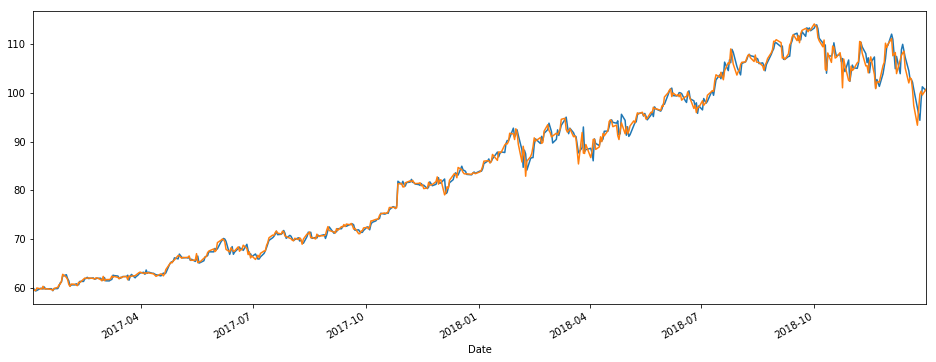

In [6]:
dataset['Open'].plot(figsize=(16, 6))
dataset.Close.plot(figsize=(16, 6))
plt.show()

In [7]:
# convert column to float type when column type is an object
#dataset["Close"] = dataset["Close"].str.replace(',', '').astype(float)

In [8]:
# 7 day rolling mean
dataset.rolling(7).mean().head(20)

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN
2017-01-04,NaN,NaN,NaN,NaN,NaN
2017-01-05,NaN,NaN,NaN,NaN,NaN
2017-01-06,NaN,NaN,NaN,NaN,NaN
2017-01-09,NaN,NaN,NaN,NaN,NaN
2017-01-10,NaN,NaN,NaN,NaN,NaN
2017-01-11,59.668571,60.064286,59.357143,59.750000,2.104657e+07
2017-01-12,59.704286,60.141429,59.331429,59.754286,2.108573e+07
2017-01-13,59.722857,60.157143,59.362857,59.808571,2.081177e+07


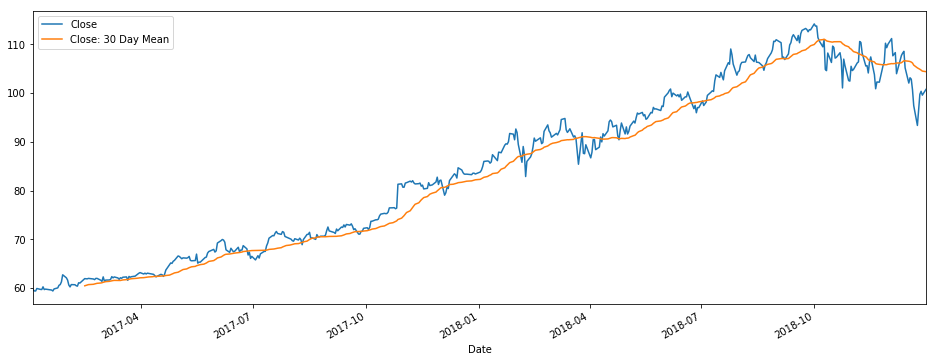

In [9]:
dataset['Close: 30 Day Mean'] = dataset.Close.rolling(window=30).mean()
dataset[['Close', 'Close: 30 Day Mean']].plot(figsize=(16, 6))
plt.show()

### Make a training dataset

In [10]:
train_data = dataset['Open']
train_data = pd.DataFrame(train_data)

In [11]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)

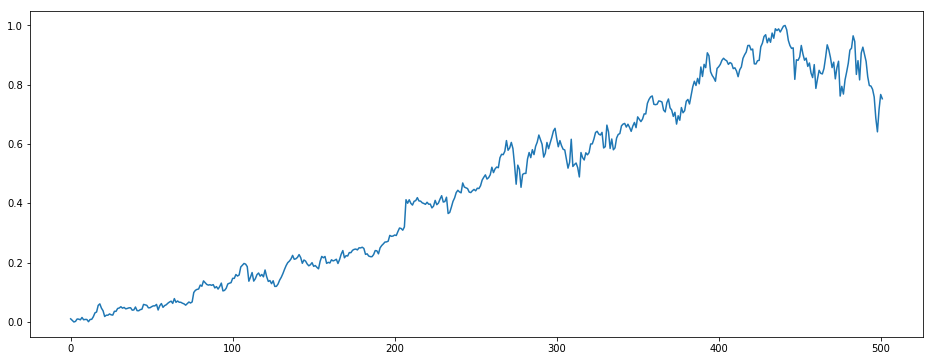

In [12]:
plt.figure(figsize=(16, 6))
plt.plot(train_data_scaled)
plt.show()

In [13]:
# Creating a data structure with 60 timesteps and 1 output
past_days = 60
X_train = []
y_train = []
for i in range(past_days, len(train_data_scaled)):
  X_train.append(train_data_scaled[i-past_days:i, 0])
  y_train.append(train_data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Cast
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

In [14]:
# We predict the price of next day given past 60 days prices
print(X_train.shape)
print(y_train.shape)

(442, 60, 1)
(442,)


## Build a model

In [15]:
model = tf.keras.Sequential()

In [16]:
# Adding the first LSTM layer
model.add(layers.CuDNNLSTM(units=50, input_shape=(past_days, 1)))

# Adding the output layer
model.add(layers.Dense(units=1))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 50)                10600     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,651
Trainable params: 10,651
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Check for model
model(X_train[0:2])[0]

<tf.Tensor: id=369, shape=(1,), dtype=float32, numpy=array([-0.0030066], dtype=float32)>

In [19]:
# Compiling the RNN
model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mean_squared_error')

In [20]:
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
442/442 [==============================] - 0s 516us/sample - loss: 0.1478
Epoch 2/10
442/442 [==============================] - 0s 89us/sample - loss: 0.0166
Epoch 3/10
442/442 [==============================] - 0s 83us/sample - loss: 0.0098
Epoch 4/10
442/442 [==============================] - 0s 90us/sample - loss: 0.0045
Epoch 5/10
442/442 [==============================] - 0s 94us/sample - loss: 0.0025
Epoch 6/10
442/442 [==============================] - 0s 90us/sample - loss: 0.0021
Epoch 7/10
442/442 [==============================] - 0s 89us/sample - loss: 0.0019
Epoch 8/10
442/442 [==============================] - 0s 84us/sample - loss: 0.0019
Epoch 9/10
442/442 [==============================] - 0s 78us/sample - loss: 0.0018
Epoch 10/10
442/442 [==============================] - 0s 81us/sample - loss: 0.0018


## Performance on Test-Set

Now that the model has been trained we can calculate its mean squared error on the test-set.

In [21]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2018
dataset_test = yf.download(tickers='AAPL', start='2019-01-01', end='2019-02-01', auto_adjust=True)

[*********************100%***********************]  1 of 1 downloaded


In [22]:
dataset_test.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-12-31,157.25,158.07,155.21,156.46,35003500
2019-01-02,153.64,157.56,152.98,156.64,37039700
2019-01-03,142.82,144.54,140.85,141.04,91312200
2019-01-04,143.36,147.35,142.64,147.06,58607100
2019-01-07,147.50,147.63,144.72,146.73,54777800


In [23]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22 entries, 2018-12-31 to 2019-01-31
Data columns (total 5 columns):
Open      22 non-null float64
High      22 non-null float64
Low       22 non-null float64
Close     22 non-null float64
Volume    22 non-null int64
dtypes: float64(4), int64(1)
memory usage: 1.0 KB


In [24]:
test_data = dataset_test['Open']
test_data = pd.DataFrame(test_data)

In [25]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22 entries, 2018-12-31 to 2019-01-31
Data columns (total 1 columns):
Open    22 non-null float64
dtypes: float64(1)
memory usage: 352.0 bytes


In [26]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
test_set_scaled = sc.fit_transform(test_data)

In [27]:
test_set_scaled = pd.DataFrame(test_set_scaled)
test_set_scaled.head()

,0
0,0.657403
1,0.492938
2,0.000000
3,0.024601
4,0.213212


In [28]:
# Getting the predicted stock price of 2018
dataset_total = pd.concat((dataset['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - past_days:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []

prediction_days = dataset_test.shape[0]
for i in range(past_days, past_days + prediction_days):
  X_test.append(inputs[i-past_days:i, 0])
  y_test.append(inputs[i, 0])
  
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Cast
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [29]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

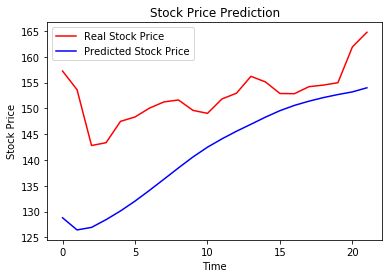

In [30]:
# Visualising the results
real_stock_price = dataset_test.Open.values
plt.plot(real_stock_price, color='red', label='Real Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Evalueate for test dataset

In [31]:
%%time
result = model.evaluate(X_test, y_test)

22/22 [==============================] - 0s 1ms/sample - loss: 0.3622
CPU times: user 96 ms, sys: 0 ns, total: 96 ms
Wall time: 94 ms


In [32]:
print("Mean Squared Error: {0:.2%}".format(result))

Mean Squared Error: 36.22%
